In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

In [88]:
df = pd.read_csv('PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
df.sort_index(inplace=True)
df.head()

,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0


In [89]:
df.tail()

,PJME_MW
Datetime,
2018-08-02 20:00:00,44057.0
2018-08-02 21:00:00,43256.0
2018-08-02 22:00:00,41552.0
2018-08-02 23:00:00,38500.0
2018-08-03 00:00:00,35486.0


In [90]:
print(df.shape)
print('*' * 50)
print(df.info())
print('*' * 50)
print(df.isna().sum())

(145366, 1)
**************************************************
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-01-01 01:00:00 to 2018-08-03 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145366 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB
None
**************************************************
PJME_MW    0
dtype: int64


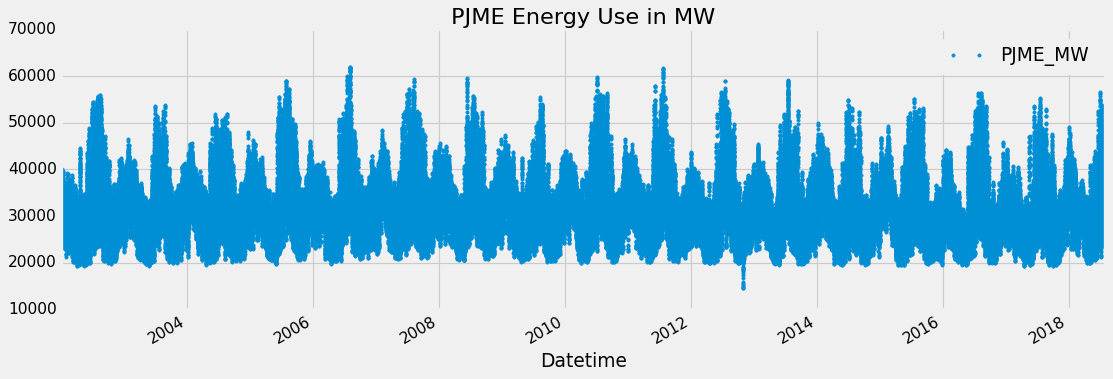

In [91]:
df.plot(style='.',
        figsize=(15, 5),
        title='PJME Energy Use in MW')
plt.show()

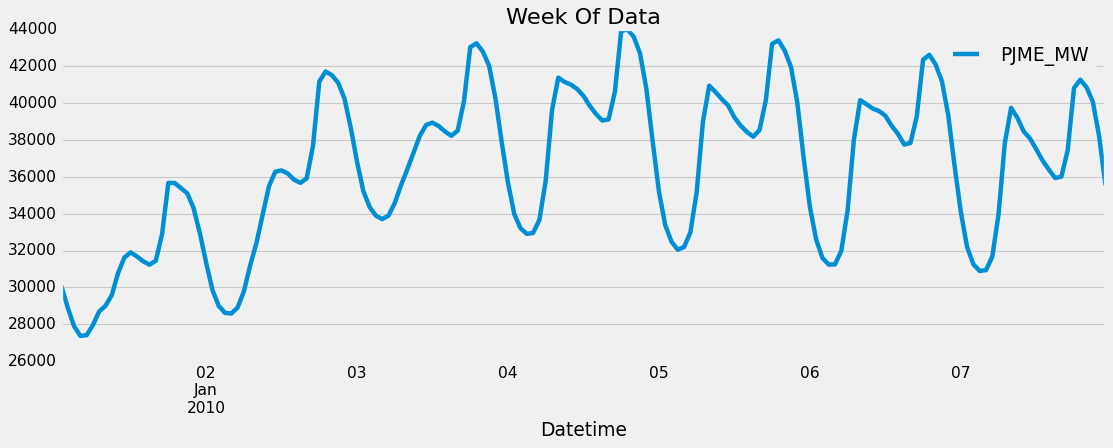

In [92]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

# Feature Creation

In [93]:
def add_lag_features(df, target, lags):
    for lag in lags:
        df[f'{target}_lag_{lag}'] = df[target].shift(lag)
    return df

lags = [1, 2, 24, 168, 336, 8760, 17520]
df = add_lag_features(df, 'PJME_MW', lags)
df.head()

,PJME_MW,PJME_MW_lag_1,PJME_MW_lag_2,PJME_MW_lag_24,PJME_MW_lag_168,PJME_MW_lag_336,PJME_MW_lag_8760,PJME_MW_lag_17520
Datetime,,,,,,,,
2002-01-01 01:00:00,30393.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-01 02:00:00,29265.0,30393.0,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-01 03:00:00,28357.0,29265.0,30393.0,NaN,NaN,NaN,NaN,NaN
2002-01-01 04:00:00,27899.0,28357.0,29265.0,NaN,NaN,NaN,NaN,NaN
2002-01-01 05:00:00,28057.0,27899.0,28357.0,NaN,NaN,NaN,NaN,NaN


In [94]:
def create_features(df):

    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    df['month_name'] = df.index.strftime('%b')
    df['weekday_name'] = df.index.strftime('%a')

    return df

df = create_features(df)
df.head()

,PJME_MW,PJME_MW_lag_1,PJME_MW_lag_2,PJME_MW_lag_24,PJME_MW_lag_168,PJME_MW_lag_336,PJME_MW_lag_8760,PJME_MW_lag_17520,hour,dayofweek,quarter,month,dayofyear,dayofmonth,weekofyear,month_name,weekday_name
Datetime,,,,,,,,,,,,,,,,,
2002-01-01 01:00:00,30393.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,1,1,1,1,Jan,Tue
2002-01-01 02:00:00,29265.0,30393.0,NaN,NaN,NaN,NaN,NaN,NaN,2,1,1,1,1,1,1,Jan,Tue
2002-01-01 03:00:00,28357.0,29265.0,30393.0,NaN,NaN,NaN,NaN,NaN,3,1,1,1,1,1,1,Jan,Tue
2002-01-01 04:00:00,27899.0,28357.0,29265.0,NaN,NaN,NaN,NaN,NaN,4,1,1,1,1,1,1,Jan,Tue
2002-01-01 05:00:00,28057.0,27899.0,28357.0,NaN,NaN,NaN,NaN,NaN,5,1,1,1,1,1,1,Jan,Tue


# Visualize our Feature / Target Relationship

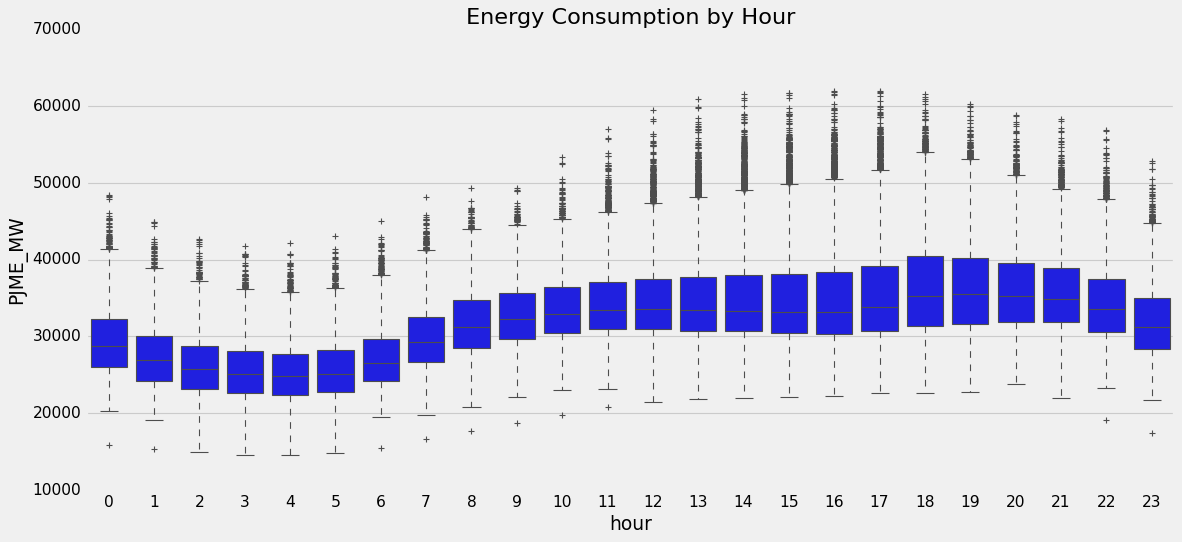

In [95]:
fig, ax = plt.subplots(figsize=(15,7))

sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('Energy Consumption by Hour')

plt.tight_layout()
plt.show()

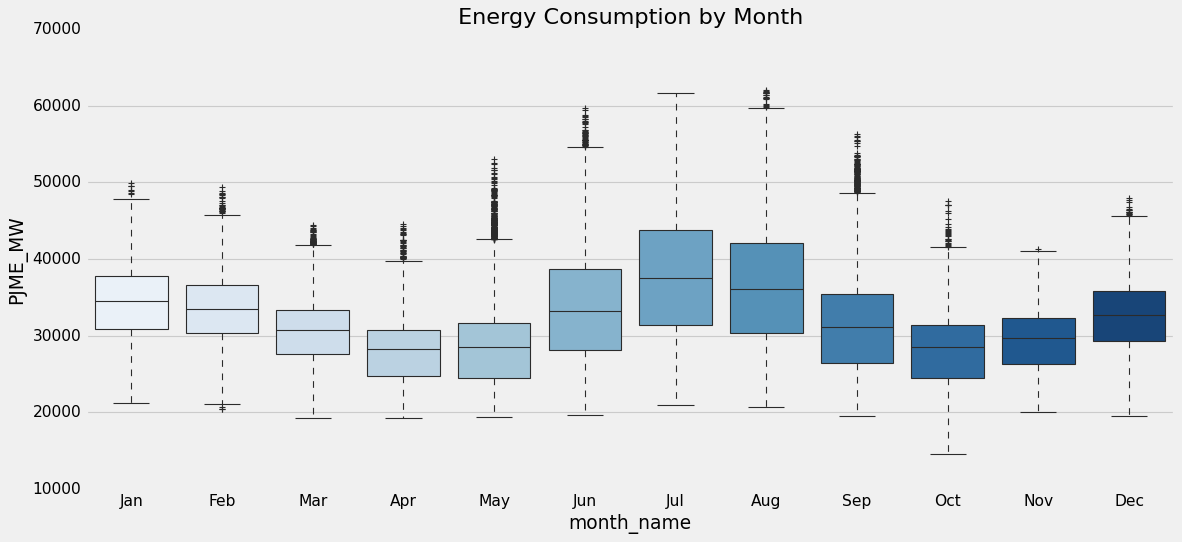

In [96]:
fig, ax = plt.subplots(figsize=(15, 7))

sns.boxplot(data=df, x='month_name', y='PJME_MW', palette='Blues')
ax.set_title('Energy Consumption by Month')

plt.tight_layout()
plt.show()

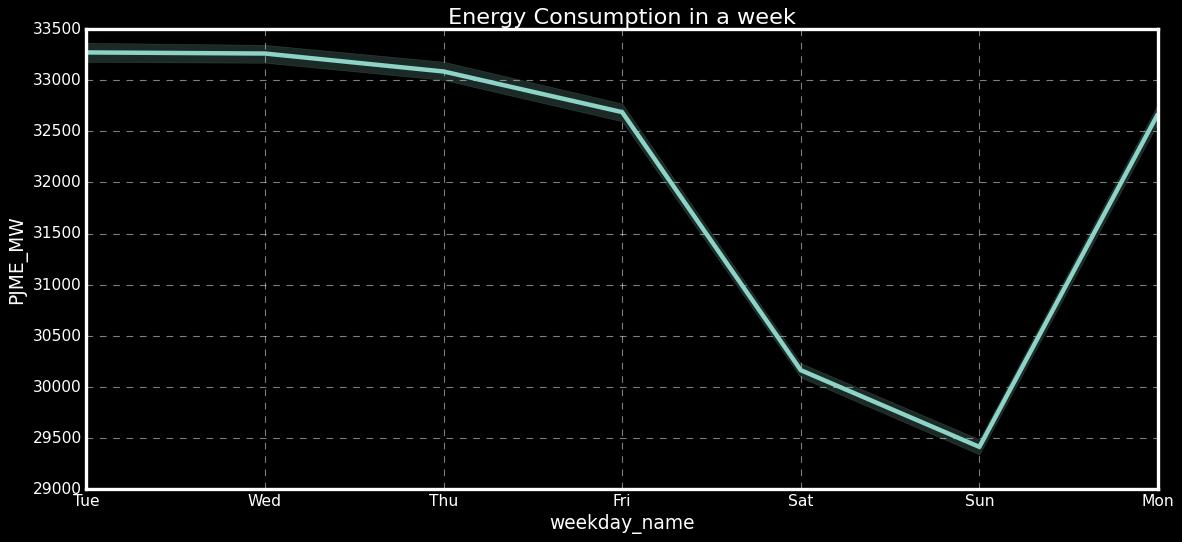

In [97]:
plt.style.use('dark_background')

fig, ax = plt.subplots(figsize=(15, 7))
sns.lineplot(data=df, x='weekday_name', y='PJME_MW')
ax.set_title('Energy Consumption in a week')
ax.grid(True, linestyle='--', alpha=0.5, color='white')

plt.tight_layout()
plt.show()

# Train / Test Split

In [98]:
train = df.loc[df.index < '2015-01-01']
test = df.loc[df.index >= '2015-01-01']

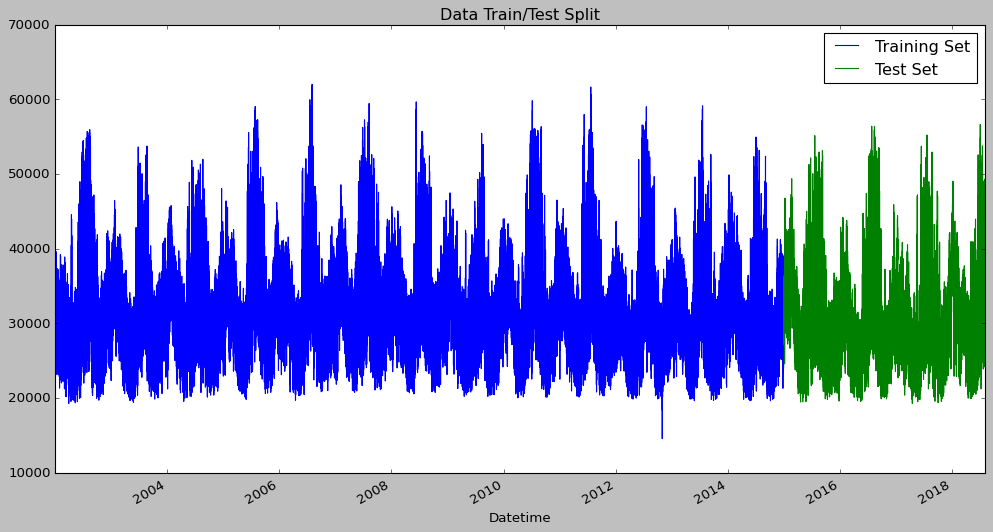

In [99]:
plt.style.use('classic')

fig, ax = plt.subplots(figsize=(15, 8))
train['PJME_MW'].plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test['PJME_MW'].plot(ax=ax, label='Test Set')
ax.legend(['Training Set', 'Test Set'])
plt.show()

# Create our Model

In [100]:
# train = create_features(train)
# test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month'] + [f'PJME_MW_lag_{lag}' for lag in lags]
TARGET = 'PJME_MW'


X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [101]:
X_train.shape, X_test.shape, y_train.shape,  y_test.shape

((113926, 12), (31440, 12), (113926,), (31440,))

In [102]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=750,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=50)

[0]	validation_0-rmse:32598.95832	validation_1-rmse:31659.48817
[50]	validation_0-rmse:19770.50630	validation_1-rmse:19154.89461
[100]	validation_0-rmse:12021.31573	validation_1-rmse:11590.94803
[150]	validation_0-rmse:7349.41945	validation_1-rmse:7047.36885
[200]	validation_0-rmse:4545.26958	validation_1-rmse:4322.51914
[250]	validation_0-rmse:2879.38768	validation_1-rmse:2708.85411
[300]	validation_0-rmse:1910.79800	validation_1-rmse:1780.10853
[350]	validation_0-rmse:1370.98893	validation_1-rmse:1277.79991
[400]	validation_0-rmse:1083.31773	validation_1-rmse:1023.68549
[450]	validation_0-rmse:933.61414	validation_1-rmse:900.85338
[500]	validation_0-rmse:855.13568	validation_1-rmse:843.14655
[550]	validation_0-rmse:809.90264	validation_1-rmse:810.98010
[600]	validation_0-rmse:779.70236	validation_1-rmse:788.48474
[650]	validation_0-rmse:757.91853	validation_1-rmse:772.49046
[700]	validation_0-rmse:739.70300	validation_1-rmse:758.22111
[749]	validation_0-rmse:725.07616	validation_1-rm

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=750, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [103]:
xgb_predictions = reg.predict(X_test)

xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
xgb_mae = mean_absolute_error(y_test, xgb_predictions)
print(f'XGBoost RMSE: {xgb_rmse:.2f}')
print(f'XGBoost MAE: {xgb_mae:.2f}')

XGBoost RMSE: 746.35
XGBoost MAE: 577.28


# Feature Importance

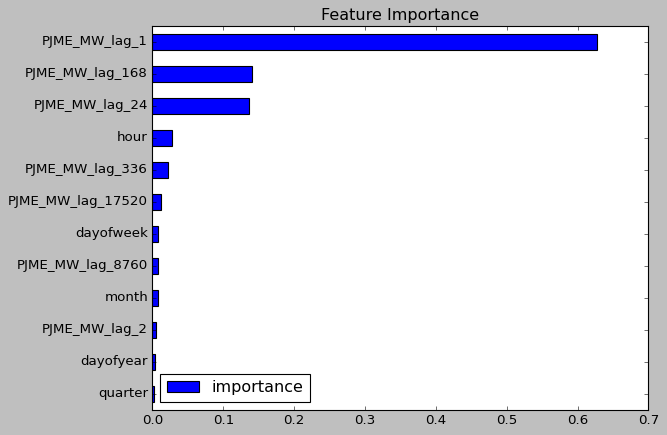

In [104]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Forecast on Test

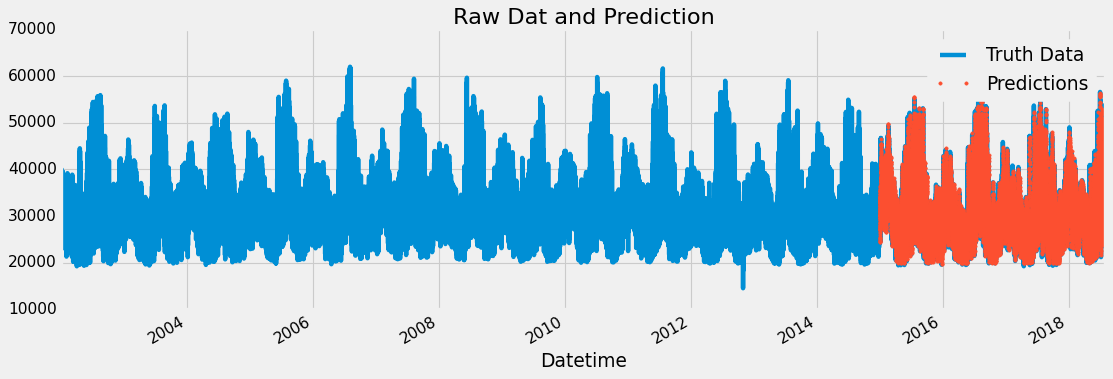

In [105]:
test['prediction'] = reg.predict(X_test)

plt.style.use('fivethirtyeight')
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

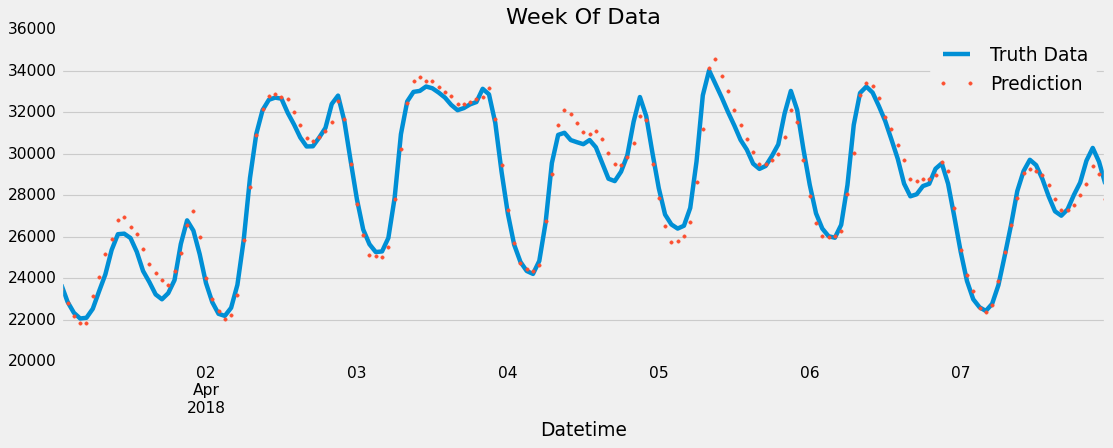

In [106]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

# Calculate Error
- Look at the worst and best predicted days

In [107]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
error_by_date = test.groupby(['date'])['error'].mean().sort_values()

In [108]:
error_by_date.head()

,error
date,
2017-03-31,217.676514
2017-05-27,219.145182
2015-06-28,223.979980
2015-04-08,228.751058
2017-08-07,229.231608


In [109]:
error_by_date.sort_values(ascending=False).head()

,error
date,
2015-02-24,1280.568522
2018-06-18,1197.613525
2015-12-25,1178.215413
2015-11-26,1158.986003
2017-06-13,1157.998779


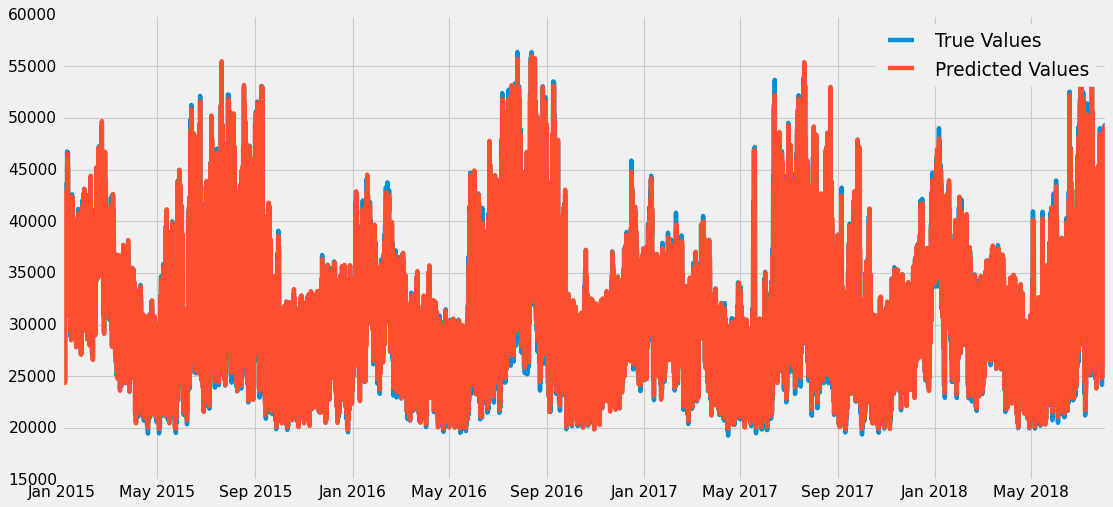

In [110]:
# Plotting the results
plt.figure(figsize=(15, 7))
plt.plot(test['PJME_MW'], label='True Values')
plt.plot(test['prediction'], label='Predicted Values')
plt.legend()
plt.show()

In [111]:
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date, periods=24*365, freq='H', inclusive ='right')
future_df = pd.DataFrame(index=future_dates)

In [112]:
df_extended = pd.concat([df, future_df])
df_extended = add_lag_features(df_extended, 'PJME_MW', lags)
df_extended = create_features(df_extended)
df_extended.head()

,PJME_MW,PJME_MW_lag_1,PJME_MW_lag_2,PJME_MW_lag_24,PJME_MW_lag_168,PJME_MW_lag_336,PJME_MW_lag_8760,PJME_MW_lag_17520,hour,dayofweek,quarter,month,dayofyear,dayofmonth,weekofyear,month_name,weekday_name,prediction
2002-01-01 01:00:00,30393.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,1,1,1,1,Jan,Tue,NaN
2002-01-01 02:00:00,29265.0,30393.0,NaN,NaN,NaN,NaN,NaN,NaN,2,1,1,1,1,1,1,Jan,Tue,NaN
2002-01-01 03:00:00,28357.0,29265.0,30393.0,NaN,NaN,NaN,NaN,NaN,3,1,1,1,1,1,1,Jan,Tue,NaN
2002-01-01 04:00:00,27899.0,28357.0,29265.0,NaN,NaN,NaN,NaN,NaN,4,1,1,1,1,1,1,Jan,Tue,NaN
2002-01-01 05:00:00,28057.0,27899.0,28357.0,NaN,NaN,NaN,NaN,NaN,5,1,1,1,1,1,1,Jan,Tue,NaN


In [113]:
X_extended = df_extended[FEATURES]
df_extended['prediction'] = reg.predict(X_extended)

future_predictions = df_extended.loc[future_dates]['prediction']

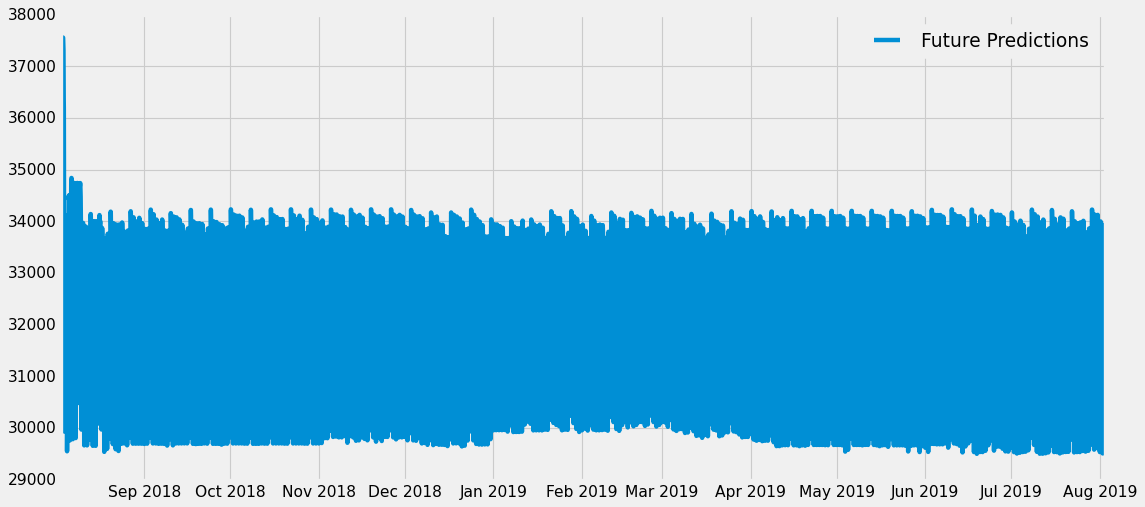

In [114]:
# Plot future predictions
plt.figure(figsize=(15, 7))
plt.plot(future_predictions, label='Future Predictions')
plt.legend()
plt.show()

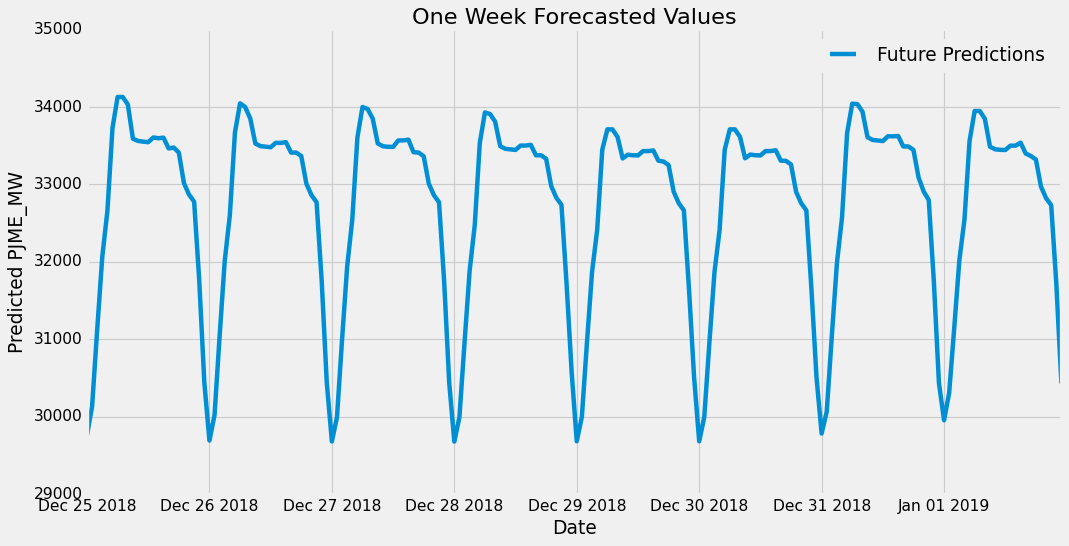

In [115]:
start_date = '2018-12-25'
end_date = '2019-01-01'
future_week_predictions = df_extended.loc[start_date:end_date]['prediction']

plt.figure(figsize=(14, 7))
plt.plot(future_week_predictions, label='Future Predictions')
plt.legend()
plt.title('One Week Forecasted Values')
plt.xlabel('Date')
plt.ylabel('Predicted PJME_MW')
plt.show()

# LSTM

In [116]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import load_model

In [117]:
data = df[['PJME_MW']].values
print(data.shape)
data

(145372, 1)


array([[30393.],
       [29265.],
       [28357.],
       ...,
       [41552.],
       [38500.],
       [35486.]])

## Scaling the Data

In [118]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
scaled_data

array([[0.3339092 ],
       [0.31014432],
       [0.29101443],
       ...,
       [0.56900874],
       [0.50470873],
       [0.44120931]])

In [119]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 24
X, y = create_sequences(scaled_data, SEQ_LENGTH)

In [120]:
X[0]

array([[0.3339092 ],
       [0.31014432],
       [0.29101443],
       [0.28136522],
       [0.28469399],
       [0.29727167],
       [0.31105025],
       [0.31709681],
       [0.32442853],
       [0.34020857],
       [0.35501949],
       [0.35714737],
       [0.34735068],
       [0.33321395],
       [0.32137364],
       [0.31973033],
       [0.35240704],
       [0.43314021],
       [0.44639208],
       [0.44443274],
       [0.43697461],
       [0.41004951],
       [0.36475298],
       [0.31642263]])

In [121]:
train_size = int(len(X) * 0.78)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [122]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((113371, 24, 1), (31977, 24, 1), (113371, 1), (31977, 1))

In [123]:
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=5, batch_size=32)

Epoch 1/5
3543/3543 [==============================] - 29s 7ms/step - loss: 0.0025
Epoch 2/5
3543/3543 [==============================] - 25s 7ms/step - loss: 4.9664e-04
Epoch 3/5
3543/3543 [==============================] - 24s 7ms/step - loss: 3.7994e-04
Epoch 4/5
3543/3543 [==============================] - 25s 7ms/step - loss: 3.3987e-04
Epoch 5/5
3543/3543 [==============================] - 24s 7ms/step - loss: 3.1784e-04


In [124]:
lstm_model.save('lstm_model.h5')

loaded_model = load_model('lstm_model.h5')

In [125]:
# lstm_predictions = loaded_model.predict(X_test)
lstm_predictions = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions)

y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

1000/1000 [==============================] - 3s 3ms/step


In [126]:
lstm_rmse = np.sqrt(mean_squared_error(y_test_actual, lstm_predictions))
lstm_mae = mean_absolute_error(y_test_actual, lstm_predictions)
print(f'LSTM RMSE: {lstm_rmse:.2f}')
print(f'LSTM MAE: {lstm_mae:.2f}')

LSTM RMSE: 468.89
LSTM MAE: 343.45


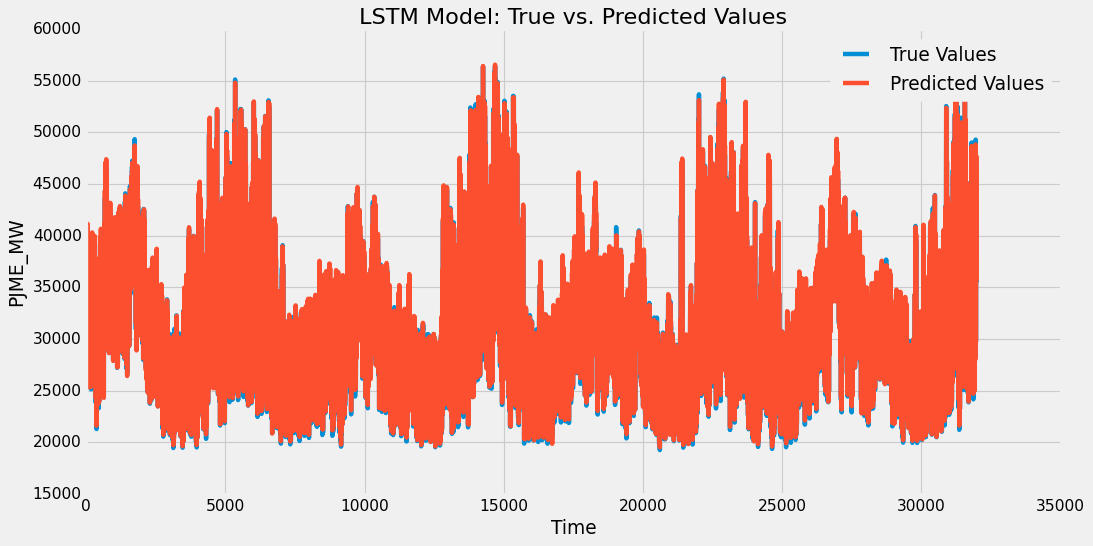

In [127]:
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, label='True Values')
plt.plot(lstm_predictions, label='Predicted Values')
plt.legend()
plt.title('LSTM Model: True vs. Predicted Values')
plt.xlabel('Time')
plt.ylabel('PJME_MW')
plt.show()

# Prophet

In [128]:
from prophet import Prophet

In [129]:
prophet_df = df[['PJME_MW']].reset_index()
prophet_df.columns = ['ds', 'y']

In [130]:
prophet_model = Prophet()
prophet_model.fit(prophet_df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpuv2v8ph8/1fau8eym.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuv2v8ph8/fy0ounnk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28621', 'data', 'file=/tmp/tmpuv2v8ph8/1fau8eym.json', 'init=/tmp/tmpuv2v8ph8/fy0ounnk.json', 'output', 'file=/tmp/tmpuv2v8ph8/prophet_modelsya6assx/prophet_model-20240730194654.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:46:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:48:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [131]:
future_dates = prophet_model.make_future_dataframe(periods=len(test), freq='H')
forecast = prophet_model.predict(future_dates)

In [132]:
prophet_predictions = forecast.set_index('ds').loc[test.index]['yhat']

prophet_rmse = np.sqrt(mean_squared_error(test['PJME_MW'], prophet_predictions))
prophet_mae = mean_absolute_error(test['PJME_MW'], prophet_predictions)

print(f'Prophet RMSE: {prophet_rmse:.2f}')
print(f'Prophet MAE: {prophet_mae:.2f}')

Prophet RMSE: 4041.63
Prophet MAE: 3108.77


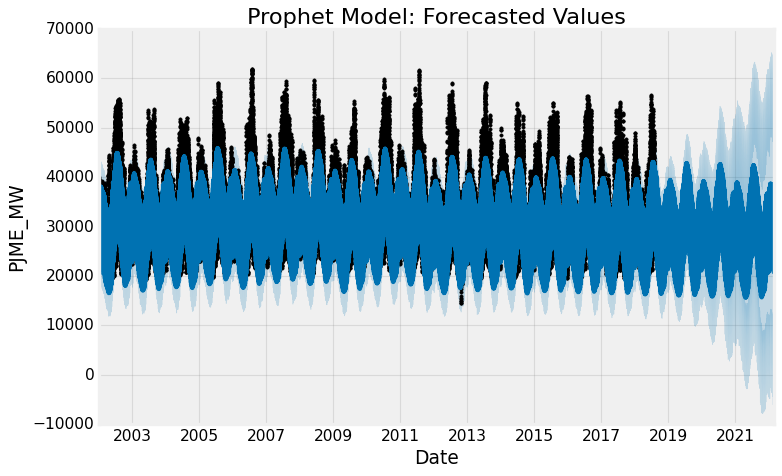

In [133]:
fig = prophet_model.plot(forecast)
plt.title('Prophet Model: Forecasted Values')
plt.xlabel('Date')
plt.ylabel('PJME_MW')
plt.show()

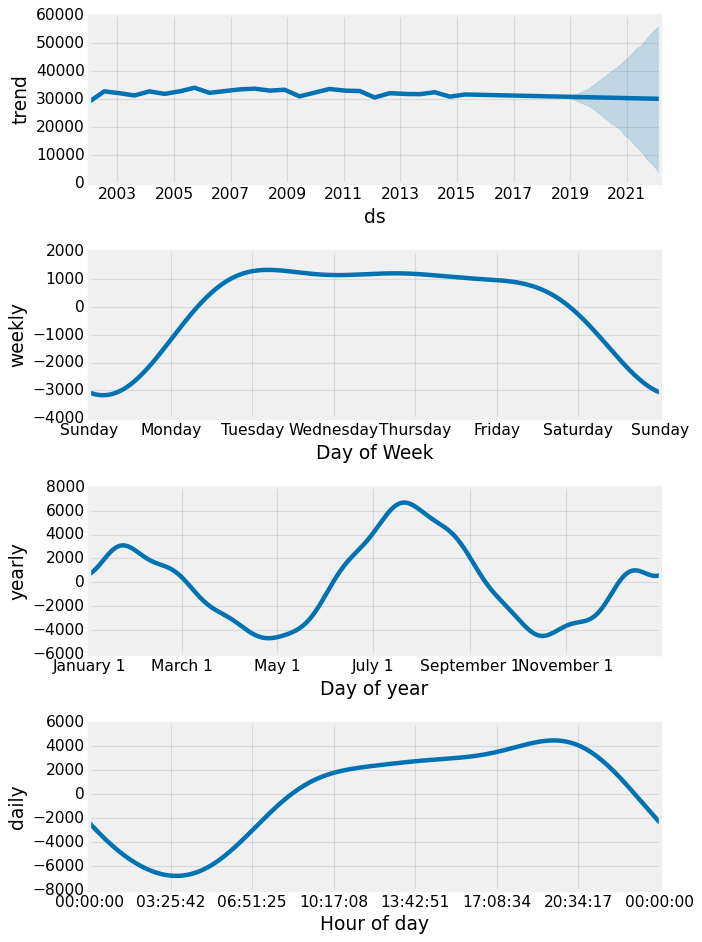

In [134]:
fig2 = prophet_model.plot_components(forecast)
plt.show()

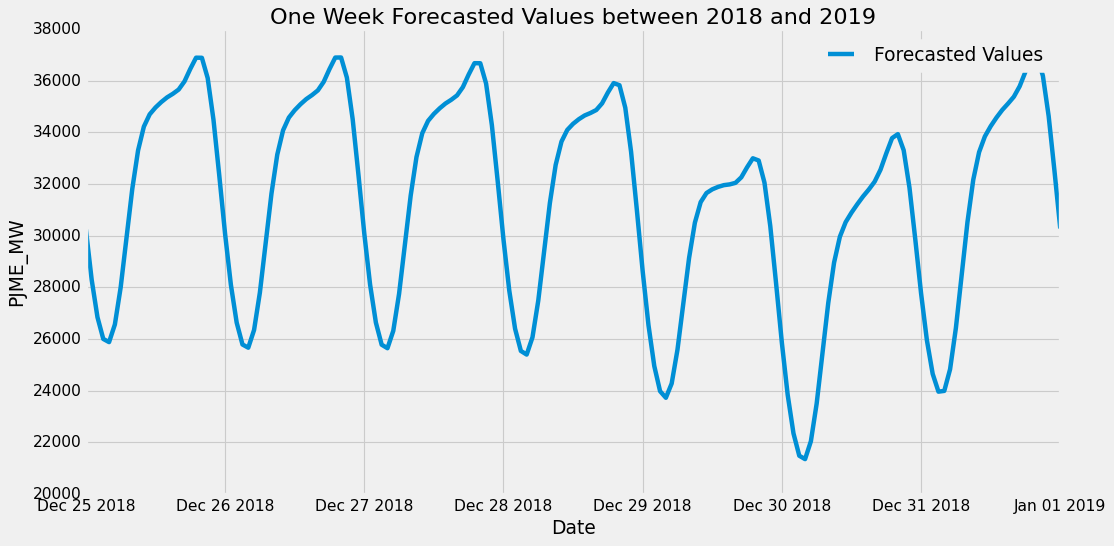

In [135]:
start_date = '2018-12-25'
end_date = '2019-01-01'
one_week_forecast = forecast[(forecast['ds'] >= start_date) & (forecast['ds'] <= end_date)]


plt.figure(figsize=(14, 7))
plt.plot(one_week_forecast['ds'], one_week_forecast['yhat'], label='Forecasted Values')
plt.legend()
plt.title('One Week Forecasted Values between 2018 and 2019')
plt.xlabel('Date')
plt.ylabel('PJME_MW')
plt.show()

# Comparing the Model

In [136]:
print(f'XGBoost RMSE: {xgb_rmse:.2f}, MAE: {xgb_mae:.2f}')
print(f'LSTM RMSE: {lstm_rmse:.2f}, MAE: {lstm_mae:.2f}')
print(f'Prophet RMSE: {prophet_rmse:.2f}, MAE: {prophet_mae:.2f}')

best_model = min([
    ('XGBoost', xgb_rmse, xgb_mae),
    ('LSTM', lstm_rmse, lstm_mae),
    ('Prophet', prophet_rmse, prophet_mae)
], key=lambda x: x[1])

print(f'The best model is {best_model[0]} with RMSE: {best_model[1]:.2f} and MAE: {best_model[2]:.2f}')

XGBoost RMSE: 746.35, MAE: 577.28
LSTM RMSE: 468.89, MAE: 343.45
Prophet RMSE: 4041.63, MAE: 3108.77
The best model is LSTM with RMSE: 468.89 and MAE: 343.45


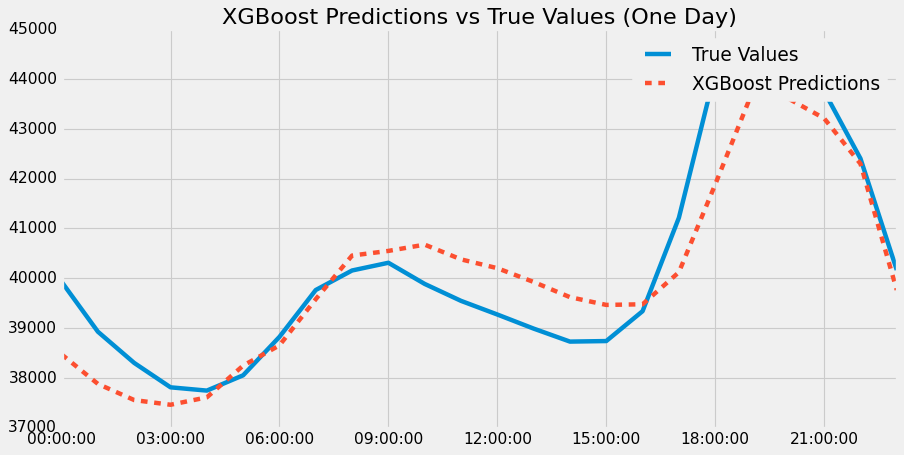

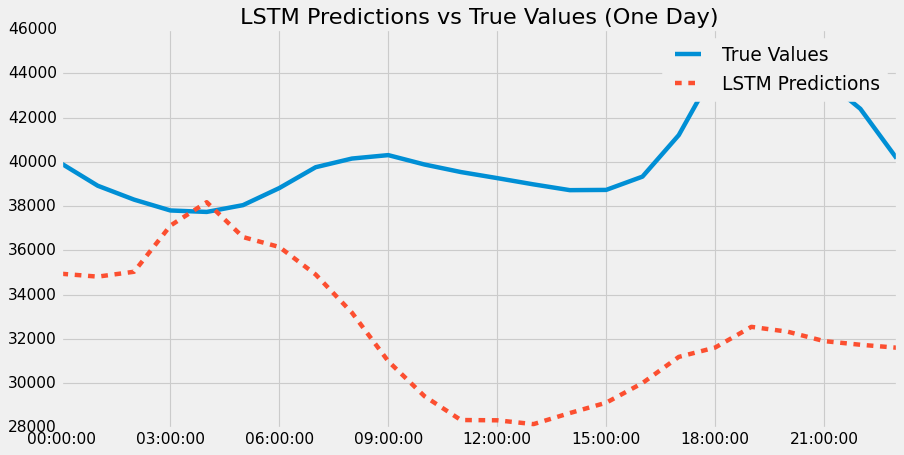

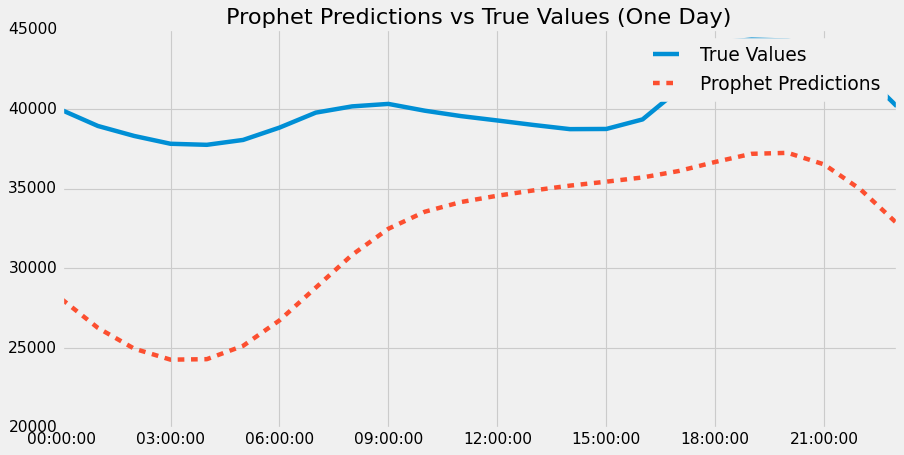

In [137]:
one_day = '2018-01-01'

plt.figure(figsize=(12, 6))
plt.plot(test.loc[one_day].index, test.loc[one_day][TARGET], label='True Values')
plt.plot(test.loc[one_day].index, xgb_predictions[test.index.get_loc(one_day)], label='XGBoost Predictions', linestyle='--')
plt.legend()
plt.title('XGBoost Predictions vs True Values (One Day)')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(test.loc[one_day].index, test.loc[one_day][TARGET], label='True Values')
plt.plot(test.loc[one_day].index, lstm_predictions[test.index.get_loc(one_day)], label='LSTM Predictions', linestyle='--')
plt.legend()
plt.title('LSTM Predictions vs True Values (One Day)')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(test.loc[one_day].index, test.loc[one_day][TARGET], label='True Values')
plt.plot(test.loc[one_day].index, prophet_predictions.loc[one_day], label='Prophet Predictions', linestyle='--')
plt.legend()
plt.title('Prophet Predictions vs True Values (One Day)')
plt.show()